<a href="https://colab.research.google.com/github/lsuhpchelp/lbrnloniworkshop2019/blob/master/day3_deeplearning_R/dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep learning with R
===

# Outline
* Install and load R packages
* `keras` package

# 1. Install and load R packages

May take a while on the Colab

R packages to be installed:

In [0]:
install.packages("keras")
install.packages("AmesHousing")
install.packages("rsample")
install.packages("yardstick")

In [0]:
getwd()
list.files()
download.file("https://apache-mxnet.s3-accelerate.dualstack.amazonaws.com/R/data/mnist_csv.zip","mnist_csv.zip")


In [2]:
list.files()

[1] "sample_data"

Load R packages:

In [0]:
library(keras)
library(AmesHousing)
library(rsample)
library(yardstick)

# 2. `keras` pakcage



## 2.1 A classification example: `MNIST` data
* MNIST (Mixed National Institute of Standards and Technology
database) is a large database of handwritten digits that is commonly
used for training various image processing systems.
* It consists of 70000 images of handwritten digits like these:

> https://drive.google.com/open?id=1DnQzdwWLR4EnWuDteA8H9hgK6JOS3vmI

* Each image is 28 pixels by 28 pixels



### 2.1.1 Data import

* `MNIST` data is included in the `keras` package and can be accessed using the `dataset_mnist()` function, which has 60000 training images and 10000 testing images.

In [0]:
mnist <- dataset_mnist()
x_train <- mnist$train$x
y_train <- mnist$train$y
x_test <- mnist$test$x
y_test <- mnist$test$y

### 2.1.2 Flatten Operation

* Since **each image is 28 pixels by 28 pixels**. We can interpret this as a big array of numbers.

* We can flatten this array into a vector of 28x28 = 784 numbers. It doesn't matter how we flatten the array, as long as we're consistent between images.
* Then, since the raw data has the grayscale values from integers ranging between 0 to 255, we convert the grayscale values into floating point values ranging between 0 and 1:

In [0]:
# reshape
x_train <- array_reshape(x_train, c(nrow(x_train), 784))
x_test <- array_reshape(x_test, c(nrow(x_test), 784))
# rescale
x_train <- x_train / 255
x_test <- x_test / 255

###2.1.3 One-hot encoding response variable `y`
* For the purposes of this tutorial, we label the y’s as "one hot vectors".
* A one hot vector is a vector which is 0 in most dimensions, and 1 in a single dimension.
*  For example, how to label an “8”?
> * \[0, 0, 0, 0, 0, 0, 0, 1, 0, 0 ]
* The one hot vector can be created using the `to_categorical()` function

In [0]:
y_train <- to_categorical(y_train, 10)
y_test <- to_categorical(y_test, 10)

## 2.2 Model definition





### 2.2.1 A sequential model with two hidden layers
* A sequential model can be created by the `keras_model_sequential()` function then a series of layer functions.
> * fully-connected layers are added by using the pipe (`%>%`) operator, each layer is defined by the `layer_dense()` function. ("dense" means fully-connected) 
> * **`units`** positive integer, dimensionality of the output space (hidden nodes). The number of hidden nodes in a hidden layer is equal to or less than the number of features in the input but this is not a rule of thumb. 
> * **`input_shape`** dimensionality of the input (integer) **not** including the samples' axis (samples' axis is 60000 in this example). This argument is required when using this layer as the first layer in a model

In [0]:
model <- keras_model_sequential() 
model %>% 
  layer_dense(units = 256, input_shape = c(784)) %>% # hidden layer 1
  layer_dense(units = 10, activation = 'softmax')    # output layer

In [0]:
summary(model)

## Quiz
1. How to calculate the total weights (203530) ? 
2. Why the hidden nodes in the first hidden layer is set to 256? 






### 2.2.2 Compiling the model 
* Next, configure the model with appropriate loss function, optimizer, and metrics via the `compile` function.
> * **`loss = 'categorical_crossentropy'`** remember for classification we use cross-entropy
> *  **`optimizer = optimizer_rmsprop()`** call an optimizer function 
> * For any classification problem you will want to set this to **`metrics = c('accuracy')`**

In [0]:
model %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = optimizer_rmsprop(),
  metrics = c('accuracy')
)

### 2.2.3 Initial model training
* The training data can be trained by the `fit()` function.
> * **`batch_size`** can be set to a power of 2 (e.g. 32, 64, 128, 256 etc.) to better feed the CPU or GPU hardware. The small values will make the training more computationally intensive while large values provide less feedback signal.
> * **`epochs`**  one epoch consists of one full training cycle on the training set. The more complex the features and relationships in your data, the more epochs you will require for your model to learn, adjust the weights, and minimize the loss function.
> * **`validation_split`** splits the training dataset into small batches for the cross-validation. The model will hold a small portion of the data (20% in the example below) for the validation purpose (and will not train on it), while the rest data is used to calculate out-of-sample error and update model coefficients.

In [0]:
history <- model %>% fit(
  x_train, y_train, 
  epochs = 30, batch_size = 128, 
  validation_split = 0.2
)

* The `history` object returned by the `fit()` function includes loss and accuracy metrics which we can plot:

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


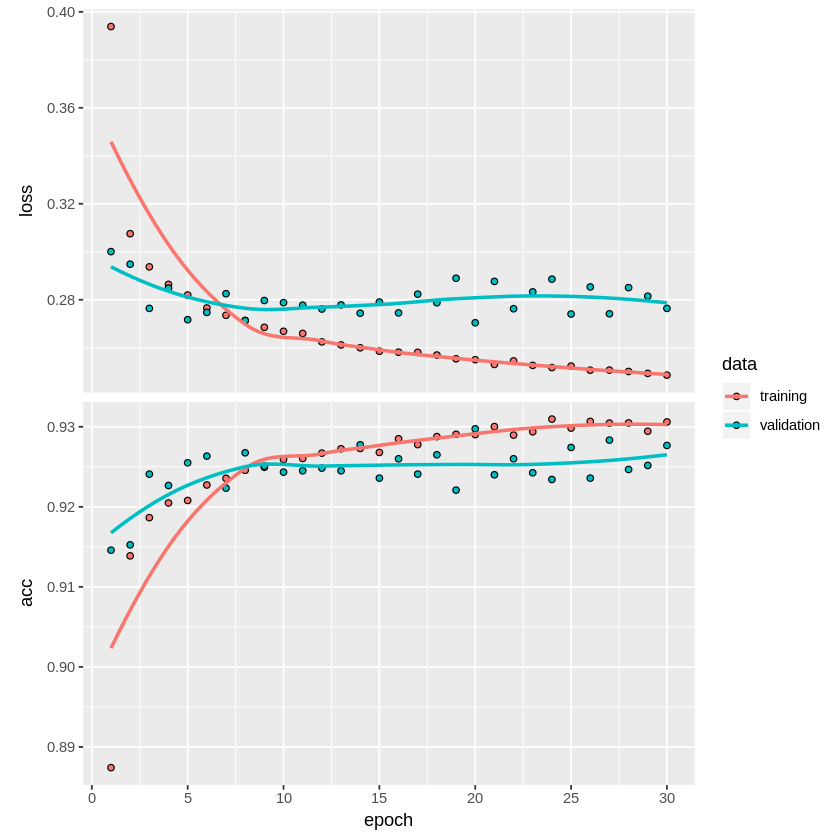

In [12]:
plot(history)

* Use the `evaluate()` function to evaluate the model’s performance on the test data:

In [14]:
model %>% evaluate(x_test, y_test)

$loss
[1] 0.2814302

$acc
[1] 0.927

* Use the `predict_classes()` function to generate predictions on new data,and compare the predicted result to the actual result

In [0]:
prediction <- model %>% predict_classes(x_test)
results <- data.frame(actual = mnist$test$y, prediction = prediction)
results

* Misclassification table

In [0]:
attach(results)
table(actual,prediction)

## 2.3 Model tuning
* The parameters in the initial model can be tuned to find the optimal model. Typically the model tuning follows these steps:
> 1. adjust hidden layers and nodes
> 2. use a different activation function 
> 3. increase epochs if the loss function is not flat
> 4. add batch normalization
> 5. add dropout
> 6. add weight regularization
> 7. adjust learning rate

### 2.3.1 Hidden layers and nodes adjustment
* Hidden layers and nodes are the first of many tuning parameters.
* A deep neural network model tends to be overfitted. So how do we examine a model is overfitted or not? 
> * check the fitting situation on the test data set. If it deteriates then the model is overfitted. 

An example with three hidden layers and 5000, 1000, and 500 nodes per layer respectively. It took a long time to finish on the Colab so indead of running the following code, I just put the result:



In [0]:
# model <- keras_model_sequential() 
# model %>% 
#   layer_dense(units = 5000, input_shape = c(784)) %>% # hidden layer 1
#   layer_dense(units = 1000) %>%    
#   layer_dense(units = 500) %>%  # hidden layer 2
#   layer_dense(units = 10, activation = 'softmax')    # output layer
# summary(model)

# model %>% compile(
#   loss = 'categorical_crossentropy',
#   optimizer = optimizer_rmsprop(),
#   metrics = c('accuracy')
# )

# history <- model %>% fit(
#   x_train, y_train, 
#   epochs = 30, batch_size = 128, 
#   validation_split = 0.2
# )


# model %>% evaluate(x_test, y_test)

#$loss
#    14.4901676010132
# $acc
#     0.101000003516674

* Typically, 2-5 hidden layers are sufficient for a  regular rectangular data. 

We can use 4 hidden layers to see if there is an improvement:


In [0]:
model <- keras_model_sequential() 
model %>% 
  layer_dense(units = 256, input_shape = c(784)) %>% # hidden layer 1
  layer_dense(units = 128) %>% # hidden layer 2  
  layer_dense(units = 64) %>%  # hidden layer 3
  layer_dense(units = 32) %>%  # hidden layer 4
  layer_dense(units = 10, activation = 'softmax')    # output layer
summary(model)

model %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = optimizer_rmsprop(),
  metrics = c('accuracy')
)

history <- model %>% fit(
  x_train, y_train, 
  epochs = 30, batch_size = 128, 
  validation_split = 0.2
)

plot(history)
model %>% evaluate(x_test, y_test)


### 2.3.2 Applying a different activation function
* The `activation` argument is for specifying the activation functions.

We can try Rectified Linear Unit (ReLU) activation function:

In [0]:
model <- keras_model_sequential() 
model %>% 
  layer_dense(units = 256, activation = "relu", input_shape = c(784)) %>% # hidden layer 1
  layer_dense(units = 128,activation = "relu") %>% # hidden layer 2  
  layer_dense(units = 64,activation = "relu") %>%  # hidden layer 3
  layer_dense(units = 32,activation = "relu") %>%  # hidden layer 4
  layer_dense(units = 10, activation = 'softmax')    # output layer
summary(model)

model %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = optimizer_rmsprop(),
  metrics = c('accuracy')
)

history <- model %>% fit(
  x_train, y_train, 
  epochs = 30, batch_size = 128, 
  validation_split = 0.2
)

plot(history)

model %>% evaluate(x_test, y_test)

### 2.3.3 Epoch adjustment

* Increase if the loss function is not flat. 
* By contrast, if epochs flattens early then there is no need to run so many epochs to save the computational resources. 
> * The `callback()` function inside the `fit()` is to help with this.

In [0]:
model <- keras_model_sequential() 
model %>% 
  layer_dense(units = 256, activation = "relu", input_shape = c(784)) %>% # hidden layer 1
  layer_dense(units = 128,activation = "relu") %>% # hidden layer 2  
  layer_dense(units = 64,activation = "relu") %>%  # hidden layer 3
  layer_dense(units = 32,activation = "relu") %>%  # hidden layer 4
  layer_dense(units = 10, activation = 'softmax')    # output layer
summary(model)

model %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = optimizer_rmsprop(),
  metrics = c('accuracy')
)

history <- model %>% fit(
  x_train, y_train, 
  epochs = 30, batch_size = 128, 
  validation_split = 0.2,
  callbacks = list(callback_early_stopping(patience = 2))
)

plot(history)

model %>% evaluate(x_test, y_test)

### 2.3.4 Batch normalization
* So far we have normalized our data before feeding it into our model. If the input  is benefiting from it, why not do the same thing also for the values in the hidden layers.
* `The layer_batch_normalization() function` normalizes the activations of the previous layer at each batch,  i.e.   applies a transformation that
maintains the mean activation close to 0 and the activation standard deviation close to 1 
* The main effect of batch normalization is that it helps with gradient propogation, which allows for deeper networks. Consequently, as the depth of your DNN increases, batch normalization becomes more important.


In [0]:
model <- keras_model_sequential() 
model %>% 
  layer_dense(units = 256, activation = "relu", input_shape = c(784)) %>% # hidden layer 1
  layer_batch_normalization() %>%
  layer_dense(units = 128,activation = "relu") %>% # hidden layer 2  
  layer_batch_normalization() %>%
  layer_dense(units = 64,activation = "relu") %>%  # hidden layer 3
  layer_batch_normalization() %>%
  layer_dense(units = 32,activation = "relu") %>%  # hidden layer 4
  layer_batch_normalization() %>%
  layer_dense(units = 10, activation = 'softmax')    # output layer
summary(model)

model %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = optimizer_rmsprop(),
  metrics = c('accuracy')
)

history <- model %>% fit(
  x_train, y_train, 
  epochs = 30, batch_size = 128, 
  validation_split = 0.2,
  callbacks = list(callback_early_stopping(patience = 2))
)

plot(history)

model %>% evaluate(x_test, y_test)

### 2.3.5 Adding dropout
* Dropout is an extremely effective, simple regularization.
* Dropout is implemented by removing nodes with some probability p (typically from 0.2 - 0.5) to prevent the model from overfitting.
* It is quite simple to apply dropout in `keras` with the  `layer_dropout() `function.

Apply a dropout rate 0.25 (drop 25% of the neurons):


In [0]:
model <- keras_model_sequential() 
model %>% 
  layer_dense(units = 256, activation = "relu", input_shape = c(784)) %>% # hidden layer 1
  layer_batch_normalization() %>%
  layer_dropout(rate = 0.25) %>%
  layer_dense(units = 128,activation = "relu") %>% # hidden layer 2  
  layer_batch_normalization() %>%
  layer_dropout(rate = 0.25) %>%
  layer_dense(units = 64,activation = "relu") %>%  # hidden layer 3
  layer_batch_normalization() %>%
  layer_dropout(rate = 0.25) %>%
  layer_dense(units = 32,activation = "relu") %>%  # hidden layer 4
  layer_batch_normalization() %>%
  layer_dropout(rate = 0.25) %>%
  layer_dense(units = 10, activation = 'softmax')    # output layer
summary(model)

model %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = optimizer_rmsprop(),
  metrics = c('accuracy')
)

history <- model %>% fit(
  x_train, y_train, 
  epochs = 30, batch_size = 128, 
  validation_split = 0.2,
)

plot(history)

model %>% evaluate(x_test, y_test)

### 2.3.6 Adding weight regularization

* Remember we put a penalty such as weight decay to obtian a more stable fit when using the `nnet` package. 
* Weight decay sacrifices some fit to the current data to obtain a more stable result.
* The `keras` package also provides weight decay regularization. 

In [0]:
model <- keras_model_sequential() 
model %>% 
  layer_dense(units = 256, activation = "relu", input_shape = c(784),kernel_regularizer = regularizer_l2(0.001)) %>% # hidden layer 1
  layer_batch_normalization() %>%
  layer_dense(units = 128,activation = "relu", kernel_regularizer = regularizer_l2(0.001)) %>% # hidden layer 2  
  layer_batch_normalization() %>%
  layer_dense(units = 64,activation = "relu", kernel_regularizer = regularizer_l2(0.001)) %>%  # hidden layer 3
  layer_batch_normalization() %>%
  layer_dense(units = 32,activation = "relu", kernel_regularizer = regularizer_l2(0.001)) %>%  # hidden layer 4
  layer_batch_normalization() %>%
  layer_dense(units = 10, activation = 'softmax')    # output layer
summary(model)

model %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = optimizer_rmsprop(),
  metrics = c('accuracy')
)

history <- model %>% fit(
  x_train, y_train, 
  epochs = 30, batch_size = 128, 
  validation_split = 0.2,
)

plot(history)

model %>% evaluate(x_test, y_test)

### 2.3.7 Learning rate adjustment
* We can automatically adjust the learning rate by a factor of 2-10 once the validation loss has stopped improving.

`callback_reduce_lr_on_plateau()` will divide the learning rate by 10 if the validation loss value does not improve for 10 epochs:

In [0]:
model <- keras_model_sequential() 
model %>% 
  layer_dense(units = 256, activation = "relu", input_shape = c(784)) %>% # hidden layer 1
  layer_batch_normalization() %>%
  layer_dropout(rate = 0.25) %>%
  layer_dense(units = 128,activation = "relu") %>% # hidden layer 2  
  layer_batch_normalization() %>%
  layer_dropout(rate = 0.25) %>%
  layer_dense(units = 64,activation = "relu") %>%  # hidden layer 3
  layer_batch_normalization() %>%
  layer_dropout(rate = 0.25) %>%
  layer_dense(units = 32,activation = "relu") %>%  # hidden layer 4
  layer_batch_normalization() %>%
  layer_dropout(rate = 0.25) %>%
  layer_dense(units = 10, activation = 'softmax')    # output layer
summary(model)

model %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = optimizer_rmsprop(),
  metrics = c('accuracy')
)

history <- model %>% fit(
  x_train, y_train, 
  epochs = 30, batch_size = 128, 
  validation_split = 0.2,
  callbacks = list(callback_reduce_lr_on_plateau(factor = 0.1, patience = 10))
)

plot(history)

model %>% evaluate(x_test, y_test)

## Quiz
* Are we missing something important about the data since the very beginning?

## 2.4 Convolution Neuron Network (CNN)
* CNN are one of the most popular deep neural networks for visual imagery analysis. 
* CNN takes advantage of 2D image structure.
* In the same convolutional layer, each neuron only "sees" a small part of the image (or layer) above it, and is using the same weights and bias.
* The infomation from the convolutional layer will be simplified by pooling layer immediately. 




### 2.4.1 Data preparation
* Import and reshape data 


In [0]:
mnist <- dataset_mnist()
x_train <- mnist$train$x
y_train <- mnist$train$y
x_test <- mnist$test$x
y_test <- mnist$test$y


# Input image dimensions
img_rows <- 28
img_cols <- 28

# Redefine  dimension of train/test inputs
x_train <- array_reshape(x_train, c(nrow(x_train), img_rows, img_cols, 1))
x_test <- array_reshape(x_test, c(nrow(x_test), img_rows, img_cols, 1))
input_shape <- c(img_rows, img_cols, 1)

x_train <- x_train / 255
x_test <- x_test / 255

cat('x_train_shape:', dim(x_train), '\n')
cat(nrow(x_train), 'train samples\n')
cat(nrow(x_test), 'test samples\n')

# One-hot encoding y
y_train <- to_categorical(y_train, 10)
y_test <- to_categorical(y_test, 10)

### 2.4.2 Model definition 
* code is obtained from https://keras.rstudio.com
* convolutional layer is defined by the `layer_conv_2d` function
* pooling layer is defined by the `layer_max_pooling_2d()` function 

In [0]:
model <- keras_model_sequential() %>%
  layer_conv_2d(filters = 32, kernel_size = c(3,3), activation = 'relu',
                input_shape = input_shape) %>% 
  layer_conv_2d(filters = 64, kernel_size = c(3,3), activation = 'relu') %>% 
  layer_max_pooling_2d(pool_size = c(2, 2)) %>% # strides will default to pool_size
  layer_dropout(rate = 0.25) %>% 
  layer_flatten() %>% 
  layer_dense(units = 128, activation = 'relu') %>% 
  layer_dropout(rate = 0.5) %>% 
  layer_dense(units = 10, activation = 'softmax')

# Compile model
model %>% compile(
  loss = loss_categorical_crossentropy,
  optimizer = optimizer_adadelta(),
  metrics = c('accuracy')
)

### 2.4.3 Model training
* The training process will take ~ 28 mins (a speed of  ~ 140 seconds per epoch) on the Colab. 
* The R kernel in the Colab doesn't support GPU at this time.  The same code will be run at 16 seconds per epoch on a GRID K520 GPU.

In [0]:
model %>% fit(
  x_train, y_train,
  batch_size = 128,
  epochs = 12,
  validation_split = 0.2
)

* Challenging 99% test accuracy. There is still a large margin for parameter tuning

In [25]:
model %>% evaluate(x_test, y_test)

$loss
[1] 0.03249367

$acc
[1] 0.9911

# Getting Help

* Documentation: http://www.hpc.lsu.edu/docs
* Contact us
> * Email ticket system: sys-help@loni.org
> * Telephone Help Desk: 225-578-0900
